In [ ]:
import yfinance as yf
import pandas as pd
import datetime

In [ ]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 1, 1)

tickers = ['ADBE', 'MSFT']


df = yf.download(tickers, start, end)['Close']
print(df)

[*********************100%***********************]  2 of 2 completed

Ticker            ADBE        MSFT
Date                              
2013-01-02   38.340000   27.620001
2013-01-03   37.750000   27.250000
2013-01-04   38.130001   26.740000
2013-01-07   37.939999   26.690001
2013-01-08   38.139999   26.549999
...                ...         ...
2018-12-24  205.160004   94.129997
2018-12-26  222.949997  100.559998
2018-12-27  225.139999  101.180000
2018-12-28  223.130005  100.389999
2018-12-31  226.240005  101.570000

[1510 rows x 2 columns]


In [ ]:
df['Price_Ratio'] = df['ADBE'] / df['MSFT']

# Moving averages for price ratio
df['MA_5'] = df['Price_Ratio'].rolling(window=5).mean()
df['MA_20'] = df['Price_Ratio'].rolling(window=20).mean()
df['MA_60'] = df['Price_Ratio'].rolling(window=60).mean()

# Rate of Change (ROC) for Price Ratio
df['ROC_5'] = df['Price_Ratio'].pct_change(periods=5) * 100  # % Change over 5 periods
df['ROC_20'] = df['Price_Ratio'].pct_change(periods=20) * 100  # % Change over 20 periods

# Standard Deviation (Volatility) for Price Ratio
df['Volatility_5'] = df['Price_Ratio'].rolling(window=5).std()
df['Volatility_20'] = df['Price_Ratio'].rolling(window=20).std()

# Lag Features for Price Ratio
df['Lag_1'] = df['Price_Ratio'].shift(1)  # Lag of 1 day
df['Lag_5'] = df['Price_Ratio'].shift(5)  # Lag of 5 days

# Drop rows with NaN values
df.dropna(inplace=True)

# Print the resulting DataFrame
print(df.head())


Ticker           ADBE       MSFT  Price_Ratio      MA_5     MA_20     MA_60  \
Date                                                                          
2013-03-28  43.520000  28.610001     1.521146  1.514580  1.482384  1.426073   
2013-04-01  43.380001  28.610001     1.516253  1.513618  1.486944  1.428208   
2013-04-02  43.849998  28.799999     1.522569  1.516356  1.491208  1.430496   
2013-04-03  43.700001  28.559999     1.530112  1.518756  1.494592  1.432231   
2013-04-04  44.209999  28.600000     1.545804  1.527177  1.498386  1.434303   

Ticker         ROC_5    ROC_20  Volatility_5  Volatility_20     Lag_1  \
Date                                                                    
2013-03-28  1.373701  7.575345      0.007881       0.027038  1.503701   
2013-04-01 -0.316156  6.400382      0.007152       0.024423  1.521146   
2013-04-02  0.907398  5.932600      0.007497       0.022681  1.516253   
2013-04-03  0.790542  4.627785      0.009774       0.023205  1.522569   
2013-04-

In [ ]:
#Preparing Datasets

# Define the target variable: Future price ratio (1 day ahead)
df['Future_Price_Ratio'] = df['Price_Ratio'].shift(-1)
df.dropna(inplace=True)

feature_columns = [
    'MA_5', 'MA_20', 'MA_60',
    'ROC_5', 'ROC_20',
    'Volatility_5', 'Volatility_20',
    'Lag_1', 'Lag_5'
]

X = df[feature_columns]
y = df['Future_Price_Ratio']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [ ]:
#Defining the Model
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [ ]:
#Evaluating the Model

from sklearn.metrics import mean_squared_error, r2_score
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.0009334430176169455
R-squared: 0.9876085764895977


In [ ]:
#Generating Predictions
df['Predicted_Price_Ratio'] = rf_model.predict(X)
print(df[['Price_Ratio', 'Future_Price_Ratio', 'Predicted_Price_Ratio']].tail())


Ticker      Price_Ratio  Future_Price_Ratio  Predicted_Price_Ratio
Date                                                              
2018-12-21     2.125623            2.179539               2.170245
2018-12-24     2.179539            2.217084               2.193600
2018-12-26     2.217084            2.225143               2.219846
2018-12-27     2.225143            2.222632               2.225749
2018-12-28     2.222632            2.227429               2.229316


In [ ]:
#Generating Trading Signals
threshold = 0.01 #1% threshold for significant difference
df['Signal'] = 'Hold'
df.loc[df['Predicted_Price_Ratio'] > (df['Price_Ratio'] * (1 + threshold)), 'Signal'] = 'Buy'
df.loc[df['Predicted_Price_Ratio'] < (df['Price_Ratio'] * (1 - threshold)), 'Signal'] = 'Sell'


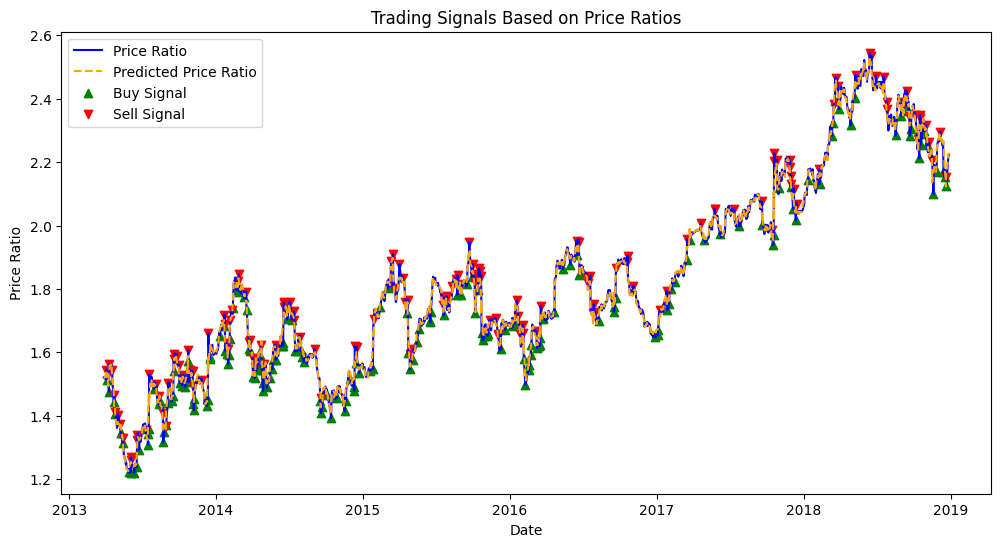

In [ ]:
#Visualization of actual and predicted ratio
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price_Ratio'], label='Price Ratio', color='blue')
plt.plot(df.index, df['Predicted_Price_Ratio'], label='Predicted Price Ratio', color='orange', linestyle='--')

#Buy Signals
buy_signals = df[df['Signal'] == 'Buy']
plt.scatter(buy_signals.index, buy_signals['Price_Ratio'], label='Buy Signal', color='green', marker='^', alpha=1)

# Sell signals
sell_signals = df[df['Signal'] == 'Sell']
plt.scatter(sell_signals.index, sell_signals['Price_Ratio'], label='Sell Signal', color='red', marker='v', alpha=1)

plt.title('Trading Signals Based on Price Ratios')
plt.xlabel('Date')
plt.ylabel('Price Ratio')
plt.legend()
plt.show()


In [ ]:
#Simulate the trading strategy
import pandas as pd
initial_cash = 100000
investment_per_trade = 1000
position = 0
cash = initial_cash

# New DataFrame for simulation
simulation_results = pd.DataFrame(index=df.index)
simulation_results['Price_Ratio'] = df['Price_Ratio']
simulation_results['Signal'] = df['Signal']
simulation_results['PnL'] = 0.0
simulation_results['Position'] = 0.0
simulation_results['Cash'] = initial_cash
simulation_results['Cumulative_PnL'] = 0.0

# Simulation of trades
for i in range(len(df)):
    signal = simulation_results['Signal'].iloc[i]
    current_ratio = simulation_results['Price_Ratio'].iloc[i]

    if signal == 'Buy':

        position += investment_per_trade / current_ratio
        cash -= investment_per_trade
        simulation_results.at[i, 'PnL'] = 0
    elif signal == 'Sell' and position > 0:

        sell_value = position * current_ratio
        profit = sell_value - (investment_per_trade * position / (investment_per_trade / current_ratio))
        cash += sell_value
        simulation_results.at[i, 'PnL'] = profit
        position = 0
    else:

        simulation_results.at[i, 'PnL'] = 0

    simulation_results.at[i, 'Position'] = position
    simulation_results.at[i, 'Cash'] = cash
    simulation_results.at[i, 'Cumulative_PnL'] = simulation_results['PnL'][:i+1].sum()


print(simulation_results)


                     Price_Ratio Signal  PnL    Position           Cash  \
Date                                                                      
2013-03-28 00:00:00     1.521146   Hold  0.0    0.000000  100000.000000   
2013-04-01 00:00:00     1.516253   Hold  0.0    0.000000  100000.000000   
2013-04-02 00:00:00     1.522569   Hold  0.0    0.000000  100000.000000   
2013-04-03 00:00:00     1.530112   Hold  0.0    0.000000  100000.000000   
2013-04-04 00:00:00     1.545804   Sell  0.0    0.000000  100000.000000   
...                          ...    ...  ...         ...            ...   
1445                         NaN    NaN  0.0  470.450201  109140.151527   
1446                         NaN    NaN  0.0  470.450201  109140.151527   
1447                         NaN    NaN  0.0  470.450201  109140.151527   
1448                         NaN    NaN  0.0  470.450201  109140.151527   
1449                         NaN    NaN  0.0  470.450201  109140.151527   

                     Cum